# Flood return period and probability 

In this lesson, we use streamflow data from a USGS stream gauge at the [South River Near Waynesboro](https://waterdata.usgs.gov/monitoring-location/USGS-01626000/). 

At this location daily stream discharge (i.e. the total volume of water in $ft^3/s$) has been reported since 1952. The data was downloaded using the USGS Water data API and we will discuss what APIs are later in the course. 

For today, the goal is to process the data in a way that we can estimate the probabilities of a different magnitude events of river discharge. 

## Learning goals

- Calculate exceedance probability and return periods associated with a flood in Python.
- Use statistical tools to fit a statistical distribution for flood probability to the data
- Predict river discharge return rates outside the observed range (e.g. the probability of a 100-year or 200-year flood)
- Understand limitations of this approach

We first load the libraries that we will need. In addition to *pandas*, *matplotlib.pyplot* and *numpy*, we will also use the [*scipy.stats* statistics package](https://docs.scipy.org/doc/scipy/reference/stats.html) to fit our model.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearson3

## Loading the data 

We are now reading the data. This is similar to the previous weeks. The only difference is that I am removing the time-zone information from the data, which makes the time display less cluttered. 

In [2]:
df = pd.read_csv('../Data/usgs_nwis_01626000_1952-10-01.csv',
                 parse_dates=[0],
                 na_values=[-999999])
df.datetime = pd.to_datetime(df.datetime).dt.tz_localize(None) # removes the time-zone information
df = df.set_index('datetime')
df.head()

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1952-10-01,1626000,38.0,A
1952-10-02,1626000,39.0,A
1952-10-03,1626000,39.0,A
1952-10-04,1626000,38.0,A
1952-10-05,1626000,38.0,A


We can see that we have a time series.  The `00060_Mean` column contains the average daily discharge in $ft^3/s$. This can be looked up in the API documentation which specifies the variable code `60` for streamflow. What does the `00060_Mean_cd` mean? 

Let's have a look.

## Exploring the data

In [5]:
df['00060_Mean_cd'].value_counts()

00060_Mean_cd
A         25814
A, e        507
P           481
P, Ice        3
Name: count, dtype: int64

In [4]:
df.iloc[:,1:].value_counts()

00060_Mean  00060_Mean_cd
35.0        A                308
38.0        A                297
36.0        A                295
34.0        A                290
31.0        A                290
                            ... 
142.0       P                  1
144.0       P                  1
147.0       P                  1
150.0       P                  1
9670.0      A                  1
Name: count, Length: 2381, dtype: int64

Without context this does not make much sense. From the API documentation we can learn that `A` and `P` are codes for *approved* and *provisional*. `e` stands for *estimated* and `Ice` is an observation code for the presence of *ice* which will affect water quality. 

In a real-world analysis, we should think about what this would mean for our analysis. For now we are OK with the data as is. 

Let's make our data a bit easier and only keep the discharge.  I am also renaming that column using [`.rename()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html). 

In [6]:
colunms_to_keep = ['00060_Mean']
df = df[colunms_to_keep]
df = df.rename(columns={'00060_Mean': 'discharge'})
df.head()	

,discharge
datetime,
1952-10-01,38.0
1952-10-02,39.0
1952-10-03,39.0
1952-10-04,38.0
1952-10-05,38.0


We look at some basic statistics. 

In [7]:
df.describe()

,discharge
count,26802.000000
mean,149.751936
std,263.541643
min,15.700000
25%,44.000000
50%,83.000000
75%,164.000000
max,9670.000000


From these we can already see that the data is pretty *skewed*. Most days there are moderate to low streamflows, but there are large extremes. The behavior of these extremes is what we want to model. 

Let's plot our data to understand this better.

<Axes: title={'center': 'Daily mean streamflow at USGS 01626000'}, xlabel='Date', ylabel='streamflow (cfs)'>

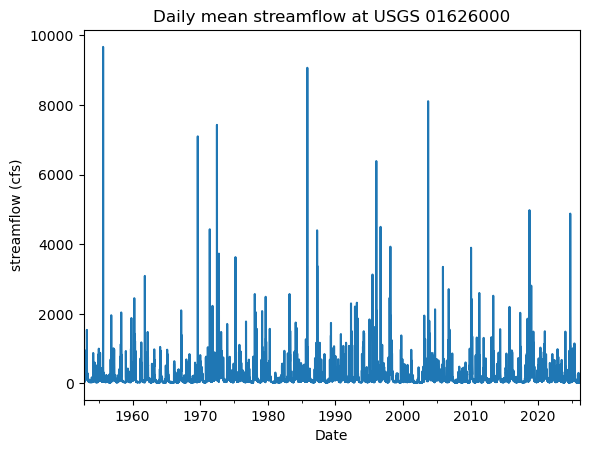

In [8]:
df['discharge'].plot(kind='line', ylabel= 'streamflow (cfs)', title='Daily mean streamflow at USGS 01626000', xlabel='Date')

This confirms our previous analysis. We can see these *"spikes"* of high streamflow.

## Calculating Annual Maxima

Since we are interested flood probability, we can simplify our data further by only retaining the annual maxima. 

In [9]:
df_annual_max = df.resample('YS').max()
df_annual_max.head()

,discharge
datetime,
1952-01-01,950.0
1953-01-01,1540.0
1954-01-01,1000.0
1955-01-01,9670.0
1956-01-01,1960.0


We can create a histogram to better understand the distribution of the annual maximum streamflow. 

Text(0.5, 1.0, 'Histogram of annual maximum streamflow at USGS 01626000')

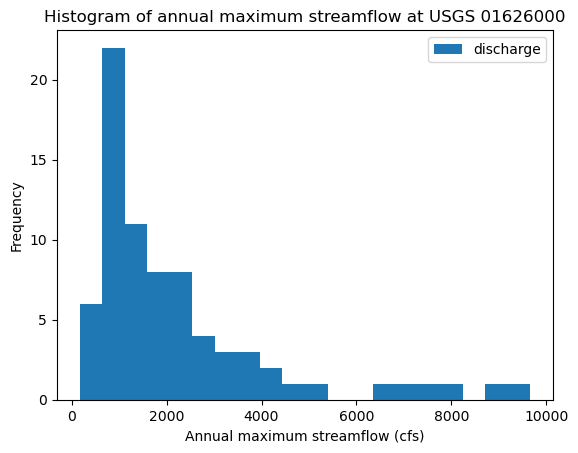

In [ ]:
fig, ax = plt.subplots()
df_annual_max.plot(kind='hist', y = 'discharge', bins = 20, ax = ax)
ax.set_xlabel('Annual maximum streamflow (cfs)')
ax.set_title('Histogram of annual maximum streamflow at USGS 01626000') ##Bin the data and then plot it

The histogram reveals a distribution with strong right-skew. This is very different from temperature and other data that you have encountered before, which is much closer to a normal distribution. 

## Calculating flood event probabilities

We are now ready to calculate the flood event return probability from the data. There are several ways to do this, that assume differences in the underlying distribution of the data. 

Here we want to calculate the probability for a flood event to exceed a certain threshold. Statistically speaking the *Exceedance Probability* is related to a [Cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function), which describes the probability that an event will take a value of less then a certain value. 

The figure below shows an empirical CDF. 

![](https://www.andata.at/files/images/blogs/cdflove/cdfvalues.png)

$\text{Exceedance Probability} = 1-CDF(x)$

One way of deriving this is to calculate a simple **Rank-oder probability** as:

$\text{Exceedance Probability} = \frac{n-i+1}{n+1}$

where $i$ is the rank order (smallest to largest) from 1 to $n$. Note that the limits of this equation vary from $n/(n+1)$ ~ 1 for the smallest events and $1/(n+1)$ for the largest events (i.e., the largest events have a very small exceedance probability).



$\text{Exceedance Probability} = 1-CDF$ 

Therefore we implement the following steps:

1. Sort the data from smallest to largest.
2. Calculate exceedance probabilities using the equation below where `n` is length of the record and `i` is the rank.
3. Calculate the inverse of the exceedance probabilities to determine return period in years.

This is implemented in the code below using `.sort_values()` to sort the dataframe and `.insert()` to create a new `'rank'` column ranging from 1 to n.

X would be the discharge for example, the idea is that you're plotting the probability that the discharge will occur. At 0.5 it would be small or the same as the median value. I can go from 0 to 1

In [11]:

sorted_data = df_annual_max.sort_values(by = 'discharge')
n = len(sorted_data) # number of data points
sorted_data.insert(0, 'rank', range(1, 1 + n)) # insert rank column
sorted_data['probability'] = (n - sorted_data["rank"] + 1) / (n + 1) # calculate probability
sorted_data['return_years'] = 1/sorted_data['probability'] # calculate return years
sorted_data

,rank,discharge,probability,return_years
datetime,,,,
2026-01-01,1,165.0,0.986842,1.013333
1981-01-01,2,312.0,0.973684,1.027027
2002-01-01,3,464.0,0.960526,1.041096
2008-01-01,4,483.0,0.947368,1.055556
2000-01-01,5,556.0,0.934211,1.070423
...,...,...,...,...
1969-01-01,71,7100.0,0.065789,15.200000
1972-01-01,72,7430.0,0.052632,19.000000
2003-01-01,73,8110.0,0.039474,25.333333


We can now plot the streamflow against the annual exceedance probability. In this case, it also makes sense to use a log-scale for the y-axis

<Axes: xlabel='Annual maximum streamflow (cfs)', ylabel='Annual exceedance probability (1/y)'>

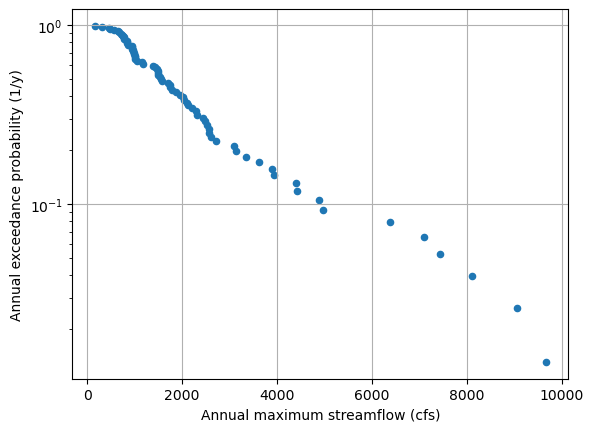

In [12]:
sorted_data.plot(kind='scatter',x='discharge', y='probability',logy=True,
                 ylabel='Annual exceedance probability (1/y)',
                 xlabel='Annual maximum streamflow (cfs)',
                 grid = True)

Or we can plot the return-period against the streamflow. We can see that this produces a curve that appears to level off which larger streamflows. 

<Axes: xlabel='Return period (years)', ylabel='Annual maximum streamflow (cfs)'>

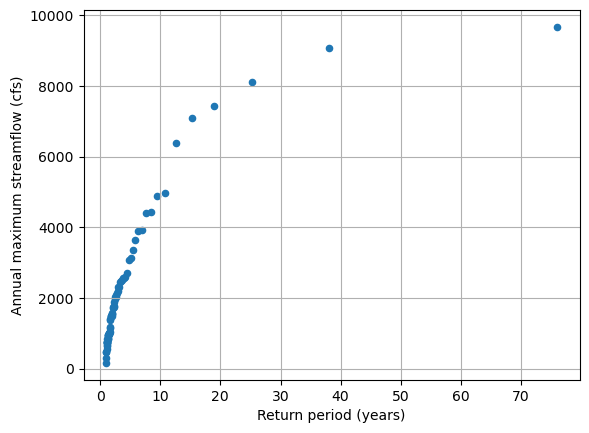

In [13]:
sorted_data.plot(kind='scatter',y='discharge', x='return_years', grid = True,
                 xlabel='Return period (years)',
                 ylabel='Annual maximum streamflow (cfs)')

## Fitting a statistical model for the return period. 

[USGS technical guidelines](https://pubs.usgs.gov/tm/04/b05/tm4b5.pdf) state that floor flow frequencies should be determined by fitting a log-Pearson-III distribution. (Don't worry if you have never heard about this.)

In response there are several manuals, that provide detailed procedures on how to fit such a distribution to data (example: [Texas Department of Transportation Hydraulic Design Manual](https://www.txdot.gov/manuals/des/hyd/chapter-4--hydrology/section-9--statistical-analysis-of-stream-gauge-da/log-pearson-type-iii-distribution-fitting-procedur.html)). 

Instead of implementing such a procedure, we will be making use of the *python's* statistical tools in the `scipy.stats` package to perform the fit. 

Because `scipy.stats` only has the *Person-Type 3* (Pearson3) distribution, we will do a log-transform on the data. 

In [14]:
import numpy as np
sorted_data['log_discharge'] = np.log10(sorted_data['discharge'])

sorted_data.head()

,rank,discharge,probability,return_years,log_discharge
datetime,,,,,
2026-01-01,1,165.0,0.986842,1.013333,2.217484
1981-01-01,2,312.0,0.973684,1.027027,2.494155
2002-01-01,3,464.0,0.960526,1.041096,2.666518
2008-01-01,4,483.0,0.947368,1.055556,2.683947
2000-01-01,5,556.0,0.934211,1.070423,2.745075


The Pearson3 distribution is defined by 3 parameters (location, scale, and shape), that can be estimated using [`scipy.stats.person3.fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearson3.html).  

In [15]:
from scipy.stats import pearson3
skew, log, scale = pearson3.fit(sorted_data['log_discharge'])
print(skew, log, scale)

0.07705260123416785 3.2140237605029798 0.3451237739859282


We can now use these parameters to estimate the relationship between discharge and probabilities calculated from the P3 distribution. 

For example, we can get the modeled probabilities for the observed discharge values. 

To do so, we can make use of the fact that the `scipi.stats.pearson3` can be used to generate the CDF. 

Recall the relationship between *Exceedance Probability* and CDF: $P = 1- CDF$

In [16]:
sorted_data['p_logPearson3']=(1-pearson3.cdf(sorted_data['log_discharge'], skew, log, scale))
sorted_data

,rank,discharge,probability,return_years,log_discharge,p_logPearson3
datetime,,,,,,
2026-01-01,1,165.0,0.986842,1.013333,2.217484,0.998601
1981-01-01,2,312.0,0.973684,1.027027,2.494155,0.983478
2002-01-01,3,464.0,0.960526,1.041096,2.666518,0.945975
2008-01-01,4,483.0,0.947368,1.055556,2.683947,0.939953
2000-01-01,5,556.0,0.934211,1.070423,2.745075,0.914711
...,...,...,...,...,...,...
1969-01-01,71,7100.0,0.065789,15.200000,3.851258,0.034600
1972-01-01,72,7430.0,0.052632,19.000000,3.870989,0.030625
2003-01-01,73,8110.0,0.039474,25.333333,3.909021,0.024039


`scipi.stats.pearson3` also provides a method to convert probabilities into discharge values.

To do so, we generate a set of return years that we convert to probabilities. We then use the inverse of the modeled P3 distribution to get predict the log of the modeled discharge. 

In [17]:
return_years = np.arange(1,500,1)
log_modeled_discharge = pearson3.isf(1/return_years, skew, log, scale)
modeled_discharge = 10**(log_modeled_discharge)

We can now plot this.

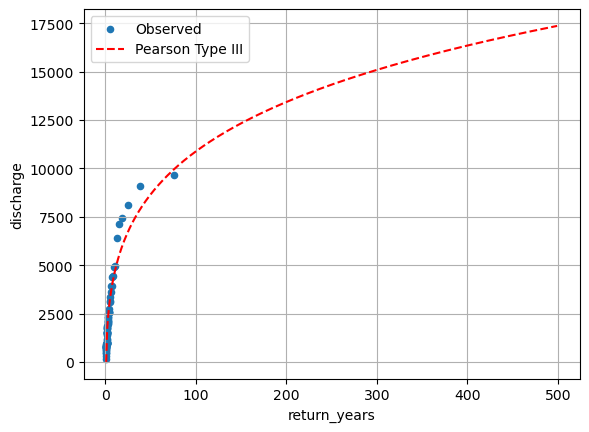

In [18]:

fix, ax = plt.subplots()
sorted_data.plot(kind='scatter',y='discharge', x='return_years', grid = True, ax=ax)

ax.plot(return_years, modeled_discharge, 'r--')

plt.legend(['Observed', 'Pearson Type III'])


### Model Evaluation 

We notice that the fit for the extreme values is not particularly good. 

One thing that we have not done, and that would typically be absolutely essential is to get a measure of the uncertainty associated with the fitted distribution. The P3-fit does not provide a direct way for quantifying the uncertainty. However, there are methods of generating a confidence interval from the data (e.g. [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))).

There are several reasons, why the model fit may be poor

- Small changes in model parameters will disproportionally affect modeled extreme values
- Extreme events are rare such that parameter fitting that provides an equal weight to all events might discount them
- The Pearson3 distribution might not be the best model
- Not all events are from the same distribution. For example, changes to the river or the climate might have led to a shift in the relationship.  
- We deviated from the official and tested fitting procedures

## Testing another distribution

The [Gumbel Distribution](https://en.wikipedia.org/wiki/Gumbel_distribution) is also frequently used for river discharge modeling. 

The Gumbel Probability Distribution is defined as 

$p = e^{-e^{-(x-u)/\alpha}}$

with 

$u = \bar{x} - 0.577 \alpha$
$\alpha = \sqrt{6}\,\frac{\sigma_x}{\pi}$

$\bar{x}$ and $\sigma_x$ are the mean and standard deviations of the observed distribution.

### Practice

See whether you can fit a Gumbel distribution to the discharge data. See whether this distribution is a better fit. 

Numpy as the exponential function and the square root as: `np.exp()`, `np.sqrt()`. 

This could then be implemented as a function in Python. 


In [19]:
def estimate_gumbel(discharge):
    p = ... # code to estimate the parameters of the Gumbel distribution
    return p